In [1]:
import  pennylane as qml
import pennylane.numpy as np

In [17]:
def U_psi(theta):
    qml.Hadamard(wires=0)
    qml.CRX(theta,wires=[0,1])
    qml.CRZ(theta,wires=[0,1])

In [25]:
def is_unsafe(alpha,beta,epsilon):
    dev = qml.device('default.qubit',wires = 2)

    @qml.qnode(dev)
    def expectation(theta):
        U_psi(theta)
        return qml.expval((qml.RX(beta,wires=0) @ qml.RX(beta,wires=1)) @ (qml.RZ(alpha,wires=0) @ qml.RZ(alpha,wires=1)))

    thetas = np.arange(-np.pi,np.pi, step = 0.1)
    for theta in thetas:
        if abs(expectation(theta))**2 > (1 - epsilon):
            return True
        return False

In [23]:
in0 = [0.1, 0.2, 0.3] # True
in1 = [1.1, 1.2, 0.3] # False
in2 = [1.1, 1.2, 0.4] # True
in3 = [0.5, 1.9, 0.7] # True

In [28]:
print(is_unsafe(*in3))

False


2. Second approach
$$|\Bra{0}*U^{*}(\Theta)(R_X(\beta)R_Z(\alpha))^{\otimes 2} U(\Theta)\Ket{0}|^2 \geqslant 1 - \epsilon$$

In [20]:
def is_unsafe2(alpha,beta,epsilon):
    o = qml.matrix((qml.RX(beta,wires=0) @ qml.RX(beta,wires=1)) @ (qml.RZ(alpha,wires=0) @ qml.RZ(alpha,wires=1)))
    z_bra = np.array([[1,0,0,0]])
    z_ket = z_bra.T

    thetas = np.arange(-np.pi,np.pi, step = 0.1)
    for theta in thetas:
        U = qml.matrix(U_psi)(theta)
        Udg = qml.matrix(qml.adjoint(U_psi))(theta)

        exp_val = z_bra @ Udg @ o @ U @ z_ket

        if abs(exp_val)**2 > (1 - epsilon):
            return True
    return False

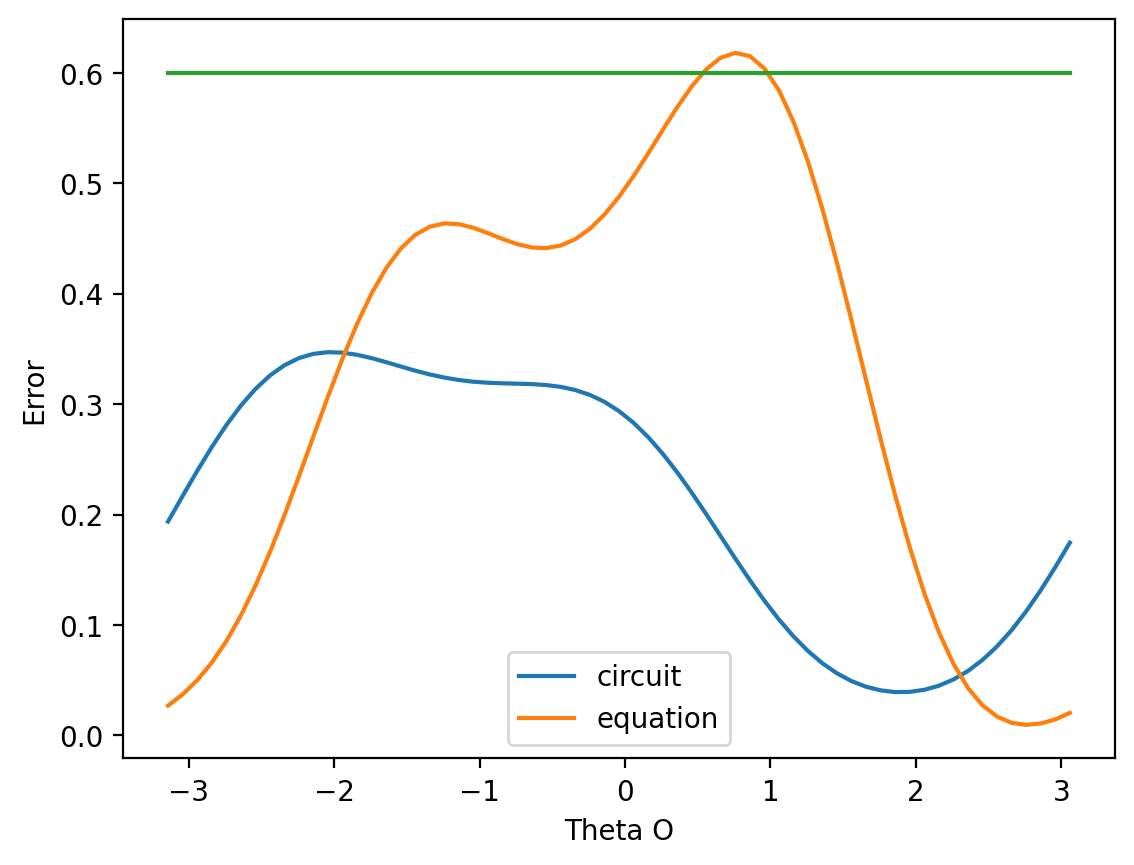

In [21]:
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

alpha,beta,epsilon = in2

vals1 = []
vals2 = []
thetas = np.arange(-np.pi,np.pi, step = 0.1)
errs = 1 - epsilon*np.ones(thetas.shape)

O = qml.matrix((qml.RX(beta,wires=0) @ qml.RX(beta,wires=1)) @ (qml.RZ(alpha,wires=0) @ qml.RZ(alpha,wires=1)))

sv = [1,0,0,0]
dev = qml.device('default.qubit',wires=2)

@qml.qnode(dev)
def expectation(angle):
    U_psi(angle)
    return qml.expval((qml.RX(beta,wires=0) @ qml.RX(beta,wires=1)) @ (qml.RZ(alpha,wires=0) @ qml.RZ(alpha,wires=1)))


for theta in thetas:
    vals1.append(abs(expectation(theta))**2)

    U = qml.matrix(U_psi)(theta)
    Udg = qml.matrix(qml.adjoint(U_psi))(theta)
    vals2.append(abs(sv @ Udg @ O @ U @ sv)**2)

plt.plot(thetas,vals1, label='circuit')
plt.plot(thetas,vals2, label='equation')
plt.plot(thetas,errs)
plt.legend()
plt.xlabel("Theta O")
plt.ylabel("Error")
plt.show()


Value of epsilon = 0.6
Circuit line is a first approach, where we use qml.expval which ignore imaginary part of value.
Equation line is the second approach, where we compute complex values to taking abs()**2.

## Secrets in Spacetime

**Backstory**
Now Zenda and Reece have a cute way to send each other private messages using entangled qubits. Trine applauds them. "Good work! But now that I think of it, superdense coding can be reversed, in a manner of speaking, to send quantum information using entanglement and classical bits. This will not only bring us to the last [Law of Infodynamics](https://en.wikipedia.org/wiki/Bennett%27s_laws), but teach us some basic facts about spacetime! Certain things have to be hidden from Nature itself." Zenda and Reece look perplexed. Trine smiles: "Wait until I show you what timbits can do!"

**From causality to encryption**
Zenda needs to send quantum states to Reece over a channel where someone could intercept the messages. They decide to encode the states they want to send with rotations on all of the qubits. To do this, they have chosen two real numbers, $\alpha$ and $\beta$, in advance, so that the states can be encoded as follows:
![circuit](./images/Secrets%20in%20Spacetime_1.png)
In this case, $U(\Theta)$ is defined as the gate that generates the state $\Ket{\psi}$ — what Zenda wants to send to Reece — that depends on a real number $\Theta$ .Thus, if someone intercepts the message, instead of getting state $\Ket{\psi}$ they will get state $(R_X(\beta)R_Z(\alpha))^{\otimes 2}\Ket{\psi}$
Although it seems like a super secure encoding procedure, it is not perfect! Once $\alpha$ and $\beta$ have been chosen, there are certain values of $\Theta$ that could make $(R_X(\beta)R_Z(\alpha))^{\otimes 2}\Ket{\psi}$ for certain states. This is a big problem — it means that someone is going to intercept the hidden state!
We will say that $\alpha$ and $\beta$ are $\epsilon$ - unsafe values if there exists a $\Theta$ such that
$$|\Bra{0}*U^{*}(\Theta)(R_X(\beta)R_Z(\alpha))^{\otimes 2} U(\Theta)\Ket{0}|^2 \geqslant 1 - \epsilon$$
Your goal is to determine if $\alpha$ and $\beta$ are unsafe values given $\epsilon$.

**Laws of Infodynamics Part II: The Fourth Law**
This box contains information that is not essential to solving the problem. Superdense coding sends two classical bits (cbits) via a qubit and half of an entangled Bell pair (ebit). Teleportation is a converse protocol, sending a qubit with two cbits and an ebit. Suppose Zenda has a state $\Ket{\psi}_{Z'}$ she wants to send to Reece, and they share a Bell state $\Ket{\beta (0,0)}_{ZR}$ , where
$$$\Ket{\beta(j,k)}_{ZR} = \frac{1}{\sqrt(2)}(\Ket{0}_Z \Ket{k}_R + (-1)^j\Ket{1}_Z\Ket{k\otimes1}_R)$$


We use the notation $\Ket{\Phi}=\Ket{\beta (0,0)}_{ZR}$ for the "canonical" Bell pair. Here, $Z'$ denotes Zenda's qubit where the state for teleportation is initially stored, and $Z$ the qubit which is initially entangled with Reece. Some algebra shows that the state of the whole system is
$$\Ket{\psi}_{Z'} \Ket{\Phi}_{ZR}=\frac{1}{2}\sum_{jk}\Ket{\beta(j,k)}_{Z'Z}X^kZ^j\Ket{\psi}_R $$

Note that in the operators $X^kZ^j$, $k$ comes before $j$. If Zenda performs a Bell measurement (i.e. measure in the basis ${\ket{\beta(j,k)}}$) on her system, she will learn two bits $j$ and $k$, and Reece will have Zenda's state in the disguised form $X^kZ^j\Ket{\psi}$ .For instance, if Zenda measures $j=k=0$, we apply the projector
$$P = \Ket{\beta(0,0)}\Bra{\beta(0,0)}_{Z'Z} ,$$
normalize, and obtain a post-measurement state
$$\Ket{\beta(0,0)}_{Z'Z}\Ket{\psi}_R.$$

After she measures the cbits $j$ and $k$, Zenda can send them to Reece, who takes off the disguise $X^kZ^j$ to find $\Ket{\psi}$ .Since an ebit and two classical bits suffice to teleport a qubit in an arbitrary state, we have the Fourth Law of Infodynamics:
$$1 ebit +2 cbits \geqslant 1 qubit$$
where $x \geqslant y$ means having resource $x$ also provides resource $y$ .The disguising operators $X^kZ^j$ seem like a nuisance, but turn out to be essential to maintaining the fabric of spacetime! Since entanglement acts in a spooky, instantaneous way at a distance, if Zenda could magically teleport $\Ket{\psi}_{Z'}$ to Reece without the disguise, she could send information faster than light. If Reece knows nothing about $j$ and $k$, it turns out that the state is perfectly disguised, in the sense that
$$\rho_R = \frac{1}{4} \sum_{jk}X^kZ^j\Ket{\psi} \Bra{\psi}(X^kZ^j)^{\dagger} = \frac{1}{2} I$$
This inspired Zenda and Reese to play around with $X$ and $Z$ rotations as a way of concealing information.

**Challenge code**
In the code below, you are given a function called is_unsafe. You must complete this function by coming up with a way — you are given total freedom, from making a variational circuit to finding an analytical solution — to determine if the given values of $\alpha$ and $\beta$ values are $\epsilon$-unsafe.

**Inputs**
As input to this problem, you are given a list(float) containing the values of $\beta$,$\beta$ , and $\epsilon$, in that order.

**Output**
This code must output a boolean — True or False — corresponding to whether the values of $\alpha$ and $\beta$ are $\epsilon$-unsafe. For example, if you determine that the given values of $\alpha$ and $\beta$ aren't $\epsilon$-unsafe, your code must output False.

In [32]:
import json
import pennylane as qml
import pennylane.numpy as np
def U_psi(theta):
    """
    Quantum function that generates |psi>, Zenda's state wants to send to Reece.

    Args:
        theta (float): Parameter that generates the state.

    """
    qml.Hadamard(wires = 0)
    qml.CRX(theta, wires = [0,1])
    qml.CRZ(theta, wires = [0,1])

def is_unsafe(alpha, beta, epsilon):
    """
    Boolean function that we will use to know if a set of parameters is unsafe.

    Args:
        alpha (float): parameter used to encode the state.
        beta (float): parameter used to encode the state.
        epsilon (float): unsafe-tolerance.

    Returns:
        (bool): 'True' if alpha and beta are epsilon-unsafe coefficients. 'False' in the other case.

    """

    o = qml.matrix((qml.RX(beta,wires=0) @ qml.RX(beta,wires=1)) @ (qml.RZ(alpha,wires=0) @ qml.RZ(alpha,wires=1)), wire_order=[0, 1])
    z_bra = np.array([[1,0,0,0]])
    z_ket = z_bra.T

    thetas = np.arange(-np.pi,np.pi, step = 0.1)
    for theta in thetas:
        U = qml.matrix(U_psi,wire_order=[0, 1])(theta)
        Udg = qml.matrix(qml.adjoint(U_psi),wire_order=[0, 1])(theta)

        exp_val = z_bra @ Udg @ o @ U @ z_ket

        if abs(exp_val)**2 > (1 - epsilon):
            return True
    return False
# These functions are responsible for testing the solution.
def run(test_case_input: str) -> str:
    ins = json.loads(test_case_input)
    output = is_unsafe(*ins)
    return str(output)

def check(solution_output: str, expected_output: str) -> None:

    def bool_to_int(string):
        if string == "True":
            return 1
        return 0

    solution_output = bool_to_int(solution_output)
    expected_output = bool_to_int(expected_output)
    assert solution_output == expected_output, "The solution is not correct."

# These are the public test cases
test_cases = [
    ('[0.1, 0.2, 0.3]', 'True'),
    ('[1.1, 1.2, 0.3]', 'False'),
    ('[1.1, 1.2, 0.4]', 'True'),
    ('[0.5, 1.9, 0.7]', 'True')
]
# This will run the public test cases locally
for i, (input_, expected_output) in enumerate(test_cases):
    print(f"Running test case {i} with input '{input_}'...")

    try:
        output = run(input_)

    except Exception as exc:
        print(f"Runtime Error. {exc}")

    else:
        if message := check(output, expected_output):
            print(f"Wrong Answer. Have: '{output}'. Want: '{expected_output}'.")

        else:
            print("Correct!")

Running test case 0 with input '[0.1, 0.2, 0.3]'...
Correct!
Running test case 1 with input '[1.1, 1.2, 0.3]'...
Correct!
Running test case 2 with input '[1.1, 1.2, 0.4]'...
Correct!
Running test case 3 with input '[0.5, 1.9, 0.7]'...
Correct!
